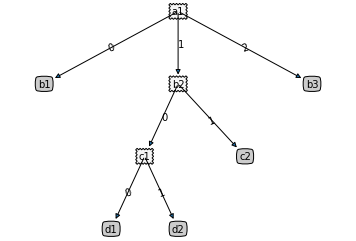

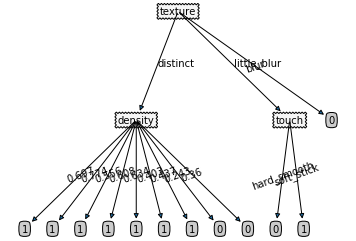

In [1]:
import pandas as pd
import numpy as np
from treeplot import *


def ReadDataset(filepath):
    f = open(filepath, encoding='UTF-8')
    file = pd.read_csv(f)
    columns = file.columns.values.tolist()[1:]
    dataSet = file.values
    data = np.array([example[1:] for example in dataSet])
    return data, columns


def calcShannonEnt(dataSet):
    '''
      计算数据集的经验熵 ：H(D) = -\sum_{k=1}^{K}\frac{C_k}{D}log_2\frac{C_k}{D}
      Ck 是属于标签k的样本个数
      D 表示数据集样本容量
      在这个数据集中，k = 2， D = 17
    :param dataSet: dataSet
    :return: shannonEnt
    '''
    # 计算公式前，注意数据的格式(array)
    numEntries = len(dataSet)  # 获取数据的行数: =  17
    labelCounts = {}  # 设置字典数据格式，想要存储的数据格式为：类别：频数
    # 用频数计算概率
    for featVec in dataSet:  # 获取数据集每一行的数据
        currentLabel = featVec[-1]  # 获取特征向量的最后一列
        # 检查字典中key是否存在
        # 如果key不存在

        if currentLabel not in labelCounts.keys():
            # 将当前的标签存于字典中，并将频数置为0
            labelCounts[currentLabel] = 0
        # 如果key存在，在当前的键值上+1
        labelCounts[currentLabel] += 1

    # 数据已准备好，计算熵
    shannonEnt = 0.0  # 初始化信息熵
    for key in labelCounts:  # 遍历出数据中所的类别
        pro = float(labelCounts[key]) / numEntries
        shannonEnt -= pro * np.math.log(pro, 2)  # 计算信息熵，这里要改一下 改成 np.math.log，否则报错
    return shannonEnt  # 返回信息熵


def splitDataSet(data, axis, value):
    '''
    指定一个axis和 value ，将数据集划分成若干个子集
    dataSet___数据集
    axis___特征索引
    value__特征值

    example: axis = 0，color这个特征，value=black, light_white等
    '''
    retDataSet = []  # 不修改原始数据集，创建一个新的列表对象
    # data原本是DataFrame格式，通过data.values可以将DataFrame格式转换为array
    for featVec in data:  # 循环遍历每一个样本
        # print(featVec[2])
        if featVec[axis] == value:
            reduceFeatVec = list(featVec[:axis])
            # ndarray没有extend()函数，需要转换为list
            reduceFeatVec.extend(featVec[axis + 1:])  # 跳过axis对应的属性
            retDataSet.append(reduceFeatVec)
    return retDataSet


def splitContinuousDataSet(dataSet, axis, value, direction):
    """
    划分连续特征值
    dataSet___待划分数据
    axis___划分数据集特征的列号，如：0，1...
    value___需要返回特征的值，属性值对应字符串
    """
    reDataSet = []
    for featVec in dataSet:
        if direction == 0:
            if featVec[axis] > value:
                reduceFeatVec = featVec[:axis]
                reduceFeatVecList = list(reduceFeatVec)
                reduceFeatVecList.extend(featVec[axis + 1:])
                reDataSet.append(reduceFeatVecList)
        else:
            if featVec[axis] <= value:
                reduceFeatVec = featVec[:axis]
                reduceFeatVecList = list(reduceFeatVec)
                reduceFeatVecList.extend(featVec[axis + 1:])
                reDataSet.append(reduceFeatVecList)
    return np.array(reDataSet)


# 选择最好的数据集划分方式
# 选择最好的数据集划分方式
def chooseBestFeatureToSplit(dataSet):
    '''
    dataSet__带划分的数据集
    labels__标签
    '''
    bestFeature = -1  # 初始化
    bestInfoGain = 0.0  # 初始化
    baseEntropy = calcShannonEnt(dataSet)  # 计算数据集总的信息熵
    numFeatures = len(dataSet[0]) - 1  # 特征个数

    # 遍历每一个特征，计算信息增益，信息增益最大的那个。然后根据特征值进行划分数据
    for i in range(numFeatures):  # 循环遍历每一个特征
        # 先将遍历出来的特征值放在list里面
        featlist = [example[i] for example in dataSet]  # 将每一个特征的特征值全都取了出来
        # print(featlist)

        # 对连续值进行处理
        if type(featlist[0]).__name__ == 'float' or type(featlist[0]).__name__ == 'int':
            # 产生n-1个候选划分点
            # 先进行排序
            sortfeatList = sorted(featlist)  # 先进行排序
            # 然后每两个值相加除以2
            splitList = []
            for j in range(len(sortfeatList) - 1):
                splitList.append((sortfeatList[j] + sortfeatList[j + 1]) / 2.0)  # 相加除以2，然后添加到splitList

            # 上述已经对连续型数据做了处理，接下来就是进行划分数据

            bestSplitEntropy = 10000  # 初始化
            slen = len(splitList)  # 离散化后的数据个数

            # 求用第j个候选划分带你划分时，得到的信息熵，并记录最佳划分点
            for j in range(slen):
                value = splitList[j]
                newEntropy = 0.0  # 初始化
                subDataSet0 = splitContinuousDataSet(dataSet, i, value, 0)
                subDataSet1 = splitContinuousDataSet(dataSet, i, value, 1)

                # 计算条件熵
                prob0 = len(subDataSet0) / len(dataSet)
                newEntropy += prob0 * calcShannonEnt(subDataSet0)

                prob1 = len(subDataSet1) / len(dataSet)
                newEntropy += prob1 * calcShannonEnt(subDataSet1)

                if newEntropy < bestSplitEntropy:
                    bestSplitEntropy = newEntropy
                    # bestplit = j

                    # 计算IfGain
                    infoGain = baseEntropy - bestSplitEntropy

                    # 对离散特征进行处理处理
        else:
            uniqueVals = set(featlist)  # 去重
            newEntropy = 0.0

            # 计算条件熵
            # 计算该特征下每种划分的信息熵
            for value in uniqueVals:
                subDataSet = splitDataSet(dataSet, i, value)
                proba = len(subDataSet) / float(len(dataSet))
                # 计算条件熵
                newEntropy += proba * calcShannonEnt(subDataSet)
            # 信息增益
            infoGain = baseEntropy - newEntropy

        if infoGain > bestInfoGain:
            bestInfoGain = infoGain
            bestFeature = i

    return bestFeature  # 返回最好的特征


# 若特征已经划分完，节点下的样本还没有统一取值，则需要进行投票
def majorityCnt(classList):
    classCount = {}
    for vote in classList:
        # 统计频数，对象：频数——字典
        #
        if vote not in classCount.key():
            classCount[vote] = 0
        classCount[vote] += 1
    return max(classCount)


def createTree(dataSet, labels):
    '''
    dataSet__代划分的数据集
    labels__数据集中所有特征的标签
    '''
    # 停止划分条件之一：标签完成相同，则直接返回该类标签
    labels = list(labels)
    classList = [example[-1] for example in dataSet]

    if classList.count(classList[0]) == len(classList):
        return classList[0]

    # 停止划分条件之二：使用完了所有特征，仍然不能将数据划分成仅包含唯一类别的分组
    # 则使用majorityCnt函数挑选次数出现最多的类别作为返回值
    if len(dataSet[0]) == 1:
        return majorityCnt(classList)  # 挑选次数出现最多的类别作为返回值
    bestFeat = chooseBestFeatureToSplit(dataSet)  # 选择最优特征
    bestFeatLabel = labels[bestFeat]  # 得到最好的特征标签
    myTree = {bestFeatLabel: {}}  # 创建树，储存数的信息

    del (labels[bestFeat])  # 删除已经使用的特征标签

    featValues = [example[bestFeat] for example in dataSet]
    uniqueValsFull = set(featValues)
    for value in uniqueValsFull:
        # 避免出现过长的小数点位数

        subLabels = labels[:]
        if type(value).__name__ == 'float':
            myTree[bestFeatLabel][round(value, 4)] = createTree(splitDataSet(dataSet, bestFeat, value), subLabels)
        else:
            myTree[bestFeatLabel][value] = createTree(splitDataSet(dataSet, bestFeat, value), subLabels)

    return myTree
file = 'watermelon_3a.csv'
data, labels = ReadDataset(file)
myTree = createTree(data, labels)
createPlot(myTree)
